# Modelling cryogenic evaporation

This notebook implements the 3-region cryogenic model that is presented in [Bostock and Scurlock, 2019](https://link.springer.com/book/10.1007/978-3-030-10641-6). It can be described as follows.
The three layers are
1. A molecular evaporation region at the surface which is probably no more than 1–2 lm in thickness, but appearing to extend to 50–100 lm in practice, 
as the capillary film remains attached to the thermocouple junction by surface tension forces when the liquid surface falls below it. 
2. A thermal conduction region enhanced by some convection, about 400 lm thick, with an extraordinarily high temperature gradient. 
3. An intermittent convection region, about 5000 lm or 5 mm thick, with a small temperature gradient, which contains the bulk of the observed thermal spikes. 
The thermal spikes also extend into region 2, but rapidly reduce in intensity as the surface is approached.

## Region 1
We start with the first region, which is called the molecular evaporation region. This region is around 1-2 $\mathrm{\mu m}$ thick. Here, the evaporation rate is given as

$$
\dot{m} = 90\alpha(T_s - T_0)
$$,

or expressed as the heat transfer rate,

$$
\dot{q} = \lambda \dot{m} = 90\lambda\alpha(T_s - T_0) = \lambda \frac{(T_s - T_0) }{R_1}
$$,

where $T_s$ is the temperature of the vapour/liquid interface, $T_0$ is the saturation temperature, $\lambda$ is the latent heat of evaporation and $\alpha$ is the molecular evaporation coefficient. For LIN, the resistance is on the order of $10^-3$.

In [1]:
dH_vap = 199e3      # [J/kg]
alpha = 10**-3      # (check!)
R_1 = (90*alpha)**-1
delta_1 = 1e-6
print(f"R_1 = {R_1: .2e}")

R_1 =  1.11e+01




## Region 2

In this, the major temperature drop occurs across a liquid layer of approximately 400 $\mu\mathrm{m}$ thickness with an extraordinarily high temperature gradient of 5000–7500 K/m.

$$
\dot{q} = \lambda \dot{m} = \mathrm{k_{eff,2}} dT/dz = \mathrm{k_{eff,2}}(T_c - T_s)/\delta_2 = \lambda \frac{(T_c - T_s) }{R_2}
$$


In [2]:
k_eff_2 = 370e-3    # [W/(m*K)]
delta_2 = 400e-6    # [m]
R_2 = dH_vap*delta_2/k_eff_2
print(f"R_2 = {R_2: .2e}")

R_2 =  2.15e+02



## Region 3

In region 3, the depth interval 0.2–5 mm, the temperature difference across this relatively thick layer is only 0.25 K corresponding to a mean temperature gradient of about 50 K/m, much smaller than in the region 2.

We use the same formulation for the evaporation rate as in region 2, namely,

$$
\dot{q} = \lambda \dot{m} = \mathrm{k_{eff,3}} dT/dz = \mathrm{k_{eff,3}}(T_b - T_c)/\delta_3 = \lambda \frac{(T_b - T_c) }{R_3}
$$


In [3]:
k_eff_3 = 48    # [W/(m*K)]
delta_3 = 5e-3  # [m]
R_3 = dH_vap*delta_3/k_eff_3
print(f"R_3 = {R_3: .2e}")

R_3 =  2.07e+01




Given the parameters and fixing the saturation and bulk superheat, we can use this to obtain the temperature layer through the regions.

## Total resistance
If we assume steady state, we know that the mass flux $\dot{m}$ must be the same for all values of $z$, i.e.

$$
\dot{m} = \frac{(T_s - T_0) }{R_1} = \frac{(T_c - T_s) }{R_2} = \frac{(T_b - T_c) }{R_3}
$$

We can then write the heat flux using an effective resistance,

$$
\dot{m} = \frac{T_b - T_0}{R_1 + R_2 + R_3} = \frac{T_b - T_0}{R_{tot}}
$$

In [4]:
T_0 = 77.31
T_b = T_0 + 3   # 3 K superheat
R_tot = R_1 + R_2 + R_3
m_dot = (T_b - T_0)/R_tot
q_dot = m_dot*dH_vap

from IPython.display import display_markdown
display_markdown(
    "Result from computations: \n\n" +
    f"$\dot{{q}}$ = {q_dot*1e-3:.2f} kW/m^2\n\n" +
    f"$\dot{{m}}$ = {m_dot*1e3:.2f} g/m^2s",
    raw=True
)

Result from computations: 

$\dot{q}$ = 2.42 kW/m^2

$\dot{m}$ = 12.15 g/m^2s

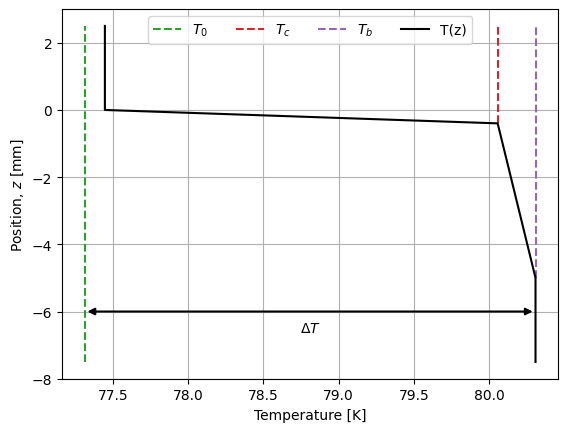

In [5]:
import matplotlib.pyplot as plt
import numpy as np

T_s = T_0 + q_dot*R_1/dH_vap
T_c = T_s + q_dot*R_2/dH_vap
T_b = T_c + q_dot*R_3/dH_vap

plt.vlines(T_0, -1.5*delta_3*1e3, 0.5e3*delta_3, color='C2', ls='dashed', label="$T_0$")
plt.vlines(T_c, -delta_2*1e3, 0.5e3*delta_3, color='C3', ls='dashed', label="$T_c$")
plt.vlines(T_b, -delta_3*1e3, 0.5e3*delta_3, color='C4', ls='dashed', label="$T_b$")
plt.plot(np.array([T_s, T_s, T_s, T_c, T_b, T_b]), 
         1e3*np.array([0.5*delta_3, 0, -delta_1, -delta_2, -delta_3, -1.5*delta_3]), 
         'k-', label='T(z)')

plt.annotate('', xy=(T_0, -6), xytext=(T_b, -6), 
            arrowprops=dict(arrowstyle='<|-|>', lw=1.5, color='black'))
plt.text((T_b + T_0)/2, -6.5, r'$\Delta T$', horizontalalignment='center', verticalalignment='center')

plt.xlabel("Temperature [K]")
plt.ylabel("Position, $z$ [mm]")
plt.grid()
plt.legend(ncol=4, loc='upper center')
plt.show()